In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [44]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [45]:
len(words)

32033

In [46]:
chars = [chr(i) for i in range(97, 97 + 26)]
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [47]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 3]) torch.Size([182625])


torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [48]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3221


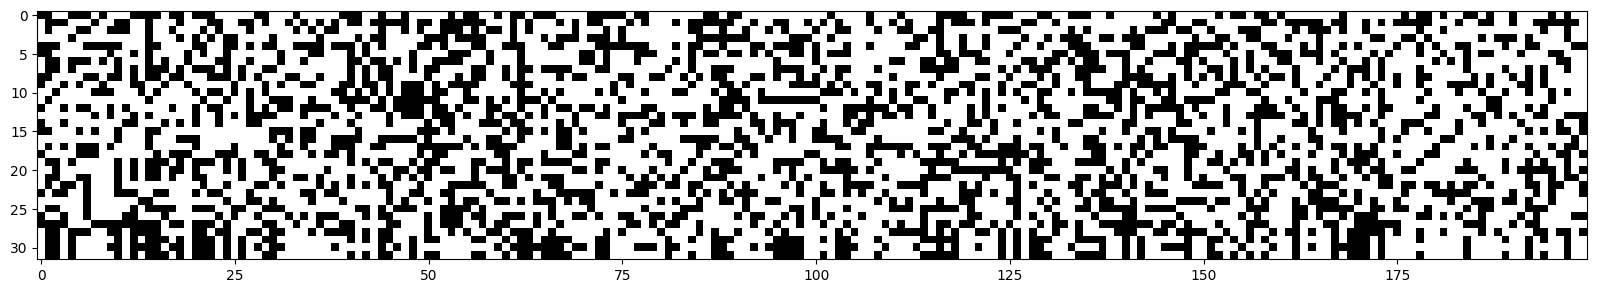

In [50]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
# from above image we can see none of the neurons is completely dead, that is none of the row is completely white
# a dead neuron means it will make the gradient 0 and none of the input gradients will be adjusted
# it results in permanent brain damage in neural network
# but in our case it does has some activations

(array([2069.,  144.,  106.,   82.,   59.,   56.,   43.,   31.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

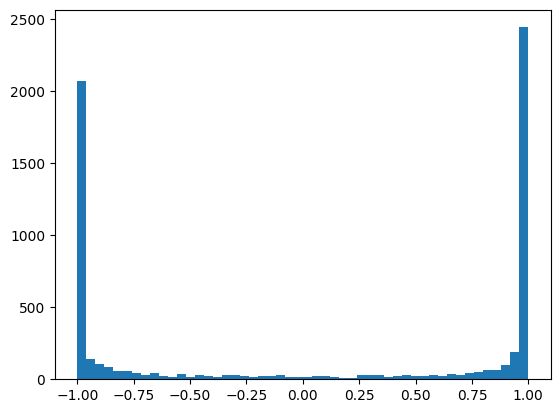

In [51]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793762, -18.31571915, -17.57350067, -16.8312822 ,
        -16.08906372, -15.34684525, -14.60462677, -13.86240829,
        -13.12018982, -12.37797134, -11.63575287, -10.89353439,
        -10.15131592,  -9.40909744,  -8.66687897,  -7.92466049,
         -7.18244202,  -6.44022354,  -5.69800507,  -4.95578659,
         -4.21356812,  -3.47134964,  -2.72913116,  -1.98691269,
         -1.24469421,  -0.50247574,   0.23974274,   0.98196121,
          1.72417969,   2.46639816,   3.20861664,   3.95083511,
          4.69305359,   5.43527206,   6.17749054,   6.91970901,
          7.66192749,   8.40414597,   9.14636444,   9.88858292,
         10.630801

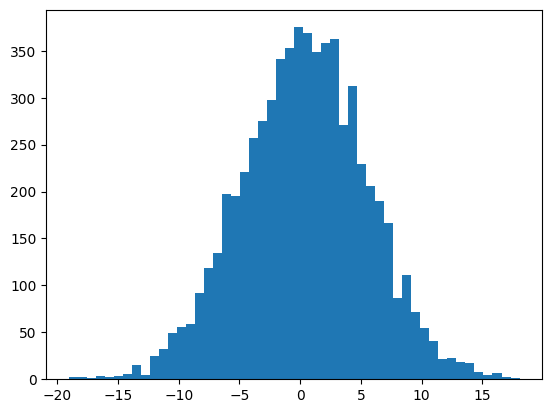

In [52]:
plt.hist(hpreact.view(-1).tolist(), 50)

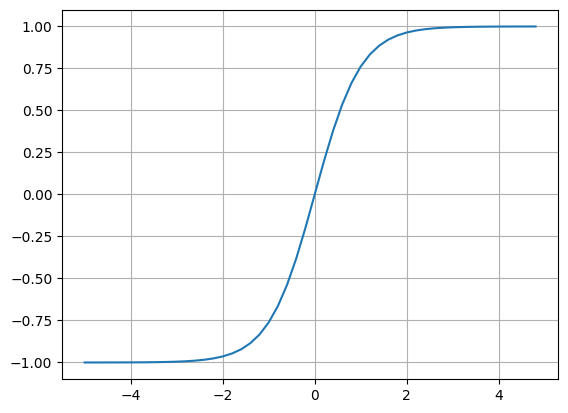

In [57]:
# the graph of tanh
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))

plt.grid()

In [ ]:
# as you can see for values above 2 and below -2, tanh reaches it's flat tails
# but currently our hpreact is taking much extreme values -15 to 15
# which we don't want
# next we will ensure that hpreact takes values near 0

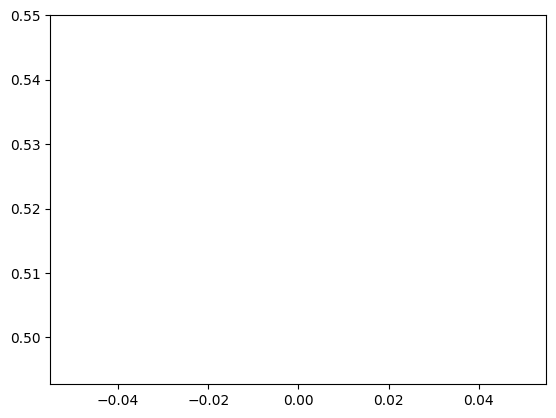

In [53]:
plt.plot(lossi)

In [54]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 3.1878931522369385
val 3.187795877456665


In [55]:
# sample from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1, block_size, n_embed)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtb.
hqvufkwmrpxqthtykhkcasskejrzhnbnfqplsyhc.
vgqhiu.
rrmuqptcmziivdyxlhggphhlm.
poin.
qbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpagmbvdjhksyjrpmqqosozswjcojqmwyljifrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxyh.
xqioloqbplbvbwdn.
ip.
qmuitjpbvfpzpddgpycsislqwkkmco.
zauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyltoorowooktbymouokfbfcw.
zoindzcs.
au.
